### Measure the time and the accuracy of adding a global pooling layer

In [25]:
from time import time
import os
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.lr_finder import LRFinder
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import Input, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Conv2D, PReLU, LeakyReLU, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.layers.merge import concatenate

from utils.utils import smooth_labels, WarmUpCosineDecayScheduler, LinearDecayScheduler

def show_result(history, metric='acc'):
        color = np.array([[31, 119, 180], [255, 127, 14]]) / 255.
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        argmax_val = np.argmax(history.history['val_%s' % metric])
        plt.plot(epochs, history.history['val_%s' % metric], label='validation', color=color[0], alpha=0.5)
        plt.plot(epochs, median_filter(history.history['val_%s' % metric]), color=color[0])
        plt.plot(epochs, history.history[metric], label='train', color=color[1], alpha=0.5)
        plt.plot(epochs, median_filter(history.history[metric]), color=color[1])

        plt.scatter(epochs[argmax_val], history.history['val_%s' % metric][argmax_val],
                    label='max val_%s %0.4f' % (metric, history.history['val_%s' % metric][argmax_val]), c='r')
        plt.legend()
        plt.xlabel('Epochs')
        plt.xticks([20, 40, 60, 80, 120, 160, 180])
        plt.grid()
        plt.ylabel(metric)
        plt.show()
        
def median_filter(v, size=5):
    stride = (size - 1) // 2
    filtered_v = []
    for i in range(len(v)):
        if i < stride or i + stride == len(v):
            filtered_v.append(v[i])
        else:
            filtered_v.append(np.mean(v[i-stride:i + stride + 1]))
    return filtered_v

ImportError: cannot import name 'LinearDecayScheduler'

In [2]:
# dataset params:
data_folder = '/home/daniel/datasets/MNIST_variations'
classes = []


In [3]:
dataset = 'MRDBI'
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()


(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [4]:
x_train = np.concatenate([data[0][0], data[2][0]], axis=0)
x_test = data[1][0]
y_train = np.concatenate([data[0][1], data[2][1]], axis=0)
y_test = data[1][1]

In [5]:
def get_layer(input_, filters, ksize, act, dropout, maxpool, original=False):
    if not original:
        act = 'relu'
        k = min(ksize[0], ksize[1])
        ksize = (k, k)
        
    if act in ['relu', 'sigmoid', 'tanh', 'elu']:
        x = Conv2D(filters, ksize, activation=act, padding='same')(input_)
    elif act == 'prelu':
        x = Conv2D(filters, ksize, padding='same')(input_)
        x = PReLU()(x)
    else:
        x = Conv2D(filters, ksize, padding='same')(input_)
        x = LeakyReLU()(x)
        
    x = BatchNormalization()(x)
    if maxpool:
        x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = keras.layers.SpatialDropout2D(dropout)(x)
    
    return x
    
def get_nn_layer(input_, units, act, dropout, original=False):
    if not original:
        act = 'sigmoid'
    if act in ['relu', 'sigmoid', 'tanh', 'elu']:
        x = Dense(units, activation=act)(input_)
    elif act == 'prelu':
        x = Dense(units)(input_)
        x = PReLU()(x)
    else:
        x = Dense(units)(input_)
        x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    return x
    


In [26]:
from utils.utils import smooth_labels, WarmUpCosineDecayScheduler
from keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D

model = 0
o = True
keras.backend.clear_session()
inp = Input(shape=data[0][0][0].shape)

if o:
    x = inp
else:
    x = BatchNormalization()(inp)

if model == 0:
    x = get_layer(x, 86, (3,5), 'leakyreLu', 0.262, 1, o)
    x = get_layer(x, 84, (5,3), 'leakyreLu', 0.319, 1, o)
    x = get_layer(x, 243, (1,3), 'prelu', 0.322, 1, o)
    #x = GlobalMaxPool2D()(x)
    x = Flatten()(x)
    x = get_nn_layer(x, 948, 'sigmoid', 0.467, o)
    x = get_nn_layer(x, 780, 'sigmoid', 0.441, o)
    x = Dense(10, activation='softmax')(x)
elif model == 1:
    x = get_layer(x, 99, (7,3), 'leakyreLu', 0.307, 0, o)
    x = get_layer(x, 192, (5,5), 'relu', 0.271, 0, o)
    x = get_layer(x, 96, (1,7), 'leakyreLu', 0.041, 1, o)
    x = get_layer(x, 177, (1,3), 'elu', 0.161, 1, o)
    x = get_layer(x, 177, (7,4), 'relu', 0.656, 0, o)
    x = Flatten()(x)
    x = get_nn_layer(x, 286, 'elu', 0.432, o)
    x = get_nn_layer(x, 411, 'sigmoid', 0.527, o)
    x = get_nn_layer(x, 621, 'elu', 0.491, o)
    x = Dense(10, activation='softmax')(x)
elif model == 2:
    x = get_layer(x, 154, (3,7), 'relu', 0.414, 1, o)
    x = get_layer(x, 164, (3,7), 'relu', 0.400, 1, o)
    x = Flatten()(x)
    x = get_nn_layer(x, 329, 'sigmoid', 0.085, o)
    x = Dense(10, activation='softmax')(x)
elif model == 3:
    x = get_layer(x, 192, (5,7), 'elu', 0.178, 1, o)
    x = get_layer(x, 222, (1,5), 'leakyreLu', 0.291, 0, o)
    x = get_layer(x, 206, (7,3), 'tanh', 0.419, 0, o)
    x = get_layer(x, 132, (3,7), 'leakyreLu', 0.380, 0, o)
    x = get_layer(x, 132, (5,7), 'relu', 0.407, 0, o)
    x = get_layer(x, 46, (5,1), 'elu', 0.176, 0, o)
    x = get_layer(x, 185, (1,3), 'leakyreLu', 0.292, 0, o)
    x = Flatten()(x)
    x = get_nn_layer(x, 362, 'elu', 0.427, o)
    x = Dense(10, activation='softmax')(x)
elif model == 4:
    x = get_layer(x, 54, (5,5), 'prelu', 0.166, 0, o)
    x = get_layer(x, 54, (5,5), 'prelu', 0.166, 0, o)
    x = get_layer(x, 54, (5,5), 'prelu', 0.138, 0, o)
    x = get_layer(x, 51, (7,3), 'prelu', 0.277, 1, o)
    x = get_layer(x, 136, (5,7), 'elu', 0.525, 1, o)
    x = Flatten()(x)
    x = get_nn_layer(x, 702, 'sigmoid', 0.301, o)
    x = Dense(10, activation='softmax')(x)
elif model == 5:
    x = get_layer(x, 121, (3,1), 'prelu', 0.175, 0, o)
    x = get_layer(x, 94, (3,3), 'prelu', 0.404, 1, o)
    x = get_layer(x, 149, (5,7), 'prelu', 0.326, 1, o)
    x = get_layer(x, 190, (3,7), 'prelu', 0.098, 1, o)
    x = Conv2D(10, 2, padding='valid', activation='softmax')(x)
    x = Flatten()(x)
    #x = Dense(10, activation='softmax')(x)
    

model = Model(inputs=inp, outputs=x)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 86)        1376      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 86)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 86)        344       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 86)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 13, 13, 86)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 84)        108444    
__________

In [36]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

epochs = 100
warmup_epochs = 0
batch_size = 128
cosine_decay = True
#epochs = 200
data_augmentation = False

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
# prepare callbacks for model saving and for learning rate reducer
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


# Create the Learning rate scheduler.
total_steps = int(epochs * data[0][1].shape[0] / batch_size)
warm_up_steps = int(warmup_epochs * data[0][1].shape[0] /batch_size)
base_steps = total_steps * (not cosine_decay)
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=warm_up_steps,
                                        hold_base_rate_steps=base_steps)

callbacks = [warm_up_lr]
#callbacks = [lr_scheduler, lr_reducer]

In [37]:
ti = time()

if not data_augmentation:
    print('Not using data augmentation.')
    h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks,
                  verbose=1)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=360,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    # fit the model on the batches generated by datagen.flow()
    h = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Elapsed time: %0.2f" % ((time() - ti) / 60.))

Not using data augmentation.
Train on 12000 samples, validate on 50000 samples
Epoch 1/100
12000/12000 [==============================] - 17s 1ms/step - loss: 0.3762 - acc: 0.8706 - val_loss: 0.3682 - val_acc: 0.8822
Epoch 2/100
12000/12000 [==============================] - 17s 1ms/step - loss: 0.3724 - acc: 0.8742 - val_loss: 0.3680 - val_acc: 0.8824
Epoch 3/100
12000/12000 [==============================] - 18s 1ms/step - loss: 0.3687 - acc: 0.8755 - val_loss: 0.3681 - val_acc: 0.8822
Epoch 4/100
12000/12000 [==============================] - 18s 1ms/step - loss: 0.3748 - acc: 0.8737 - val_loss: 0.3679 - val_acc: 0.8824
Epoch 5/100
12000/12000 [==============================] - 18s 1ms/step - loss: 0.3754 - acc: 0.8742 - val_loss: 0.3674 - val_acc: 0.8824
Epoch 6/100
12000/12000 [==============================] - 18s 1ms/step - loss: 0.3764 - acc: 0.8726 - val_loss: 0.3674 - val_acc: 0.8824
Epoch 7/100
12000/12000 [==============================] - 18s 1ms/step - loss: 0.3642 - acc:

KeyboardInterrupt: 

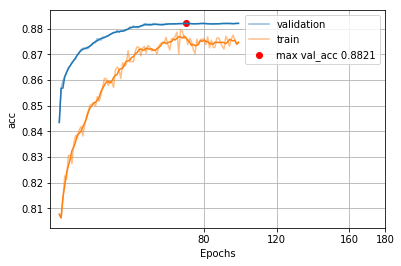

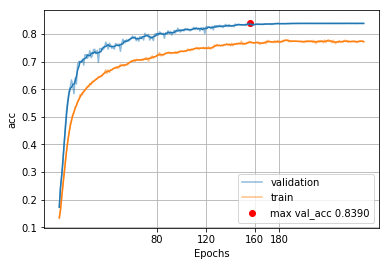

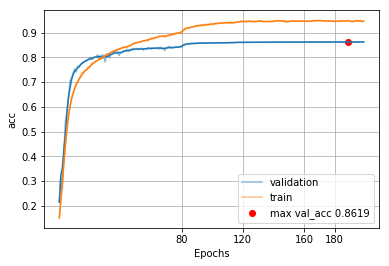

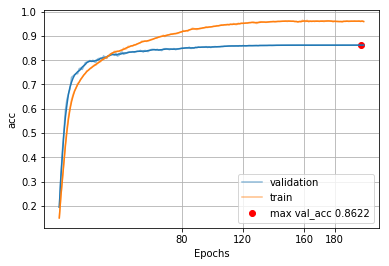

In [34]:
h_aug2 = h
show_result(h_aug2)
show_result(h_aug)
show_result(h_lr_schedule)
show_result(h_cosine)

In [21]:
ti = time()
h = model.fit(data[0][0], data[0][1],
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data=(data[2][0], data[2][1]),
             callbacks=callbacks)
print("Test:", model.evaluate(data[1][0], data[1][1], verbose=0)[1])
print("Elapsed time: %0.2f" % ((time() - ti) / 60.))

Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 14s 1ms/step - loss: 2.8639 - acc: 0.2046 - val_loss: 1.9589 - val_acc: 0.3029
Epoch 2/75
9600/9600 [==============================] - 13s 1ms/step - loss: 1.8210 - acc: 0.3736 - val_loss: 1.4762 - val_acc: 0.4938
Epoch 3/75
9600/9600 [==============================] - 13s 1ms/step - loss: 1.4281 - acc: 0.5080 - val_loss: 1.1499 - val_acc: 0.6096
Epoch 4/75
9600/9600 [==============================] - 13s 1ms/step - loss: 1.2331 - acc: 0.5828 - val_loss: 1.0296 - val_acc: 0.6650
Epoch 5/75
9600/9600 [==============================] - 13s 1ms/step - loss: 1.1160 - acc: 0.6262 - val_loss: 0.9387 - val_acc: 0.6858
Epoch 6/75
9600/9600 [==============================] - 13s 1ms/step - loss: 1.0177 - acc: 0.6589 - val_loss: 0.8832 - val_acc: 0.7150
Epoch 7/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.9295 - acc: 0.6897 - val_loss: 0.8411 - val_acc: 0.7204
Epoch 8

Epoch 61/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1183 - acc: 0.9619 - val_loss: 0.4675 - val_acc: 0.8829
Epoch 62/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1088 - acc: 0.9656 - val_loss: 0.4650 - val_acc: 0.8800
Epoch 63/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1181 - acc: 0.9610 - val_loss: 0.4681 - val_acc: 0.8821
Epoch 64/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1158 - acc: 0.9611 - val_loss: 0.4658 - val_acc: 0.8812
Epoch 65/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1134 - acc: 0.9629 - val_loss: 0.4633 - val_acc: 0.8825
Epoch 66/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1039 - acc: 0.9649 - val_loss: 0.4606 - val_acc: 0.8867
Epoch 67/75
9600/9600 [==============================] - 13s 1ms/step - loss: 0.1042 - acc: 0.9651 - val_loss: 0.4588 - val_acc: 0.8854
Epoch 68/75
9600/9600 [=========================

| model id | improved |dataset | val acc | test acc | time (min) | params  |
|----------|----------|--------|---------|----------|------------|---------|
|    4     | NO       | MRDBI  |  85.96  |  86.32   |   22.88    |5,305,149| 
|    4     | YES      | MRDBI  |  87.42  |  87.23   |   15.19    |3,589,465|
|    4     | YES+ks   | MRDBI  |  87.50  |  87.84   |   16.52    |3,789,465|
|    4     | YES+ks+prelu|MRDBI|  88.17  |  87.86   |   20.23    |3,984,593|
|    2     | NO       |  MB    |  99.25  |  98.94   |   13.62    |3,183,989|
|    2     | YES      |  MB    |  99.37  |  98.96   |   9.90     |2,177,645|
|    3     | NO       |  MB    |  99.12  |  99.04   |   43.53    |15,554,109|
|    3     | YES      |  MB    |  99.21  |  99.00   |   27.7     |12,658,663|
|    5     | YES      |  MBI   |  97.33  |  97.28   |   15.64    |  717,811|

In [62]:
model.trainable = False
h = model.fit(data[0][0], data[0][1],
      batch_size=128,
      epochs=5,
      verbose=1,
      validation_data=(data[2][0], data[2][1]))
print("Test:", model.evaluate(data[1][0], data[1][1], verbose=0)[1])

Train on 9600 samples, validate on 2400 samples
Epoch 1/5
9600/9600 [==============================] - 5s 499us/step - loss: 0.3220 - acc: 0.8869 - val_loss: 0.6561 - val_acc: 0.8046
Epoch 2/5
9600/9600 [==============================] - 5s 507us/step - loss: 0.3219 - acc: 0.8871 - val_loss: 0.6560 - val_acc: 0.8042
Epoch 3/5
9600/9600 [==============================] - 5s 501us/step - loss: 0.3180 - acc: 0.8908 - val_loss: 0.6556 - val_acc: 0.8054
Epoch 4/5
9600/9600 [==============================] - 5s 504us/step - loss: 0.3264 - acc: 0.8901 - val_loss: 0.6556 - val_acc: 0.8050
Epoch 5/5
9600/9600 [==============================] - 5s 501us/step - loss: 0.3240 - acc: 0.8897 - val_loss: 0.6555 - val_acc: 0.8054
Test: 0.80988


In [ ]:
|    1     | NO       | MRDBI  |  85.96  |  85.77   |   48.75    |3,841,215|